# Homework 1 - data validation & cleaning (deadline 3. 11. 2024, 23:59)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best as possible!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Most steps contain the number of features that should be treated. You can preprocess more features. However, it does not mean the teacher will give you more points. Focus on quality, not quantity.
* Properly comment on all your steps. Use Markdown cells and visualizations. Comments are evaluated for 2 points of the total, together with the final presentation of the solution. However, it is not desirable to write novels!
* This task is timewise and computationally intensive. Do not leave it to the last minute.
* Hand in a notebook that has already been run (i.e., do not delete outputs before handing in).

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  1. Check consistency (i.e., that the same things are represented in the same way) of at least **three features** where you expect problems (including the "Object Name" feature). You can propose how to clean the selected features. However, **do not apply cleaning** (in your interest) 🙂 _(1.5 points)_
  1. Select at least **two features** (i.e., one couple) where you expect integrity problems (describe your choice) and check the integrity of those features. By integrity, we mean correct logical relations between features (e.g., female names for females only). _(2 points)_
  1. Convert at least **five features** to a proper data type. Choose at least one numeric, one categorical (i.e., ordinal or nominal), and one datetime. _(1.5 points)_
  1. Find some outliers and describe your method. _(3 points, depends on creativity)_
  1. Detect missing data in at least **three features**, convert them to a proper representation (if they are already not), and impute missing values in at least **one feature** using some imputation method (i.e., imputation by mean or median is too trivial to obtain any points). _(2 + 3 points, depends on creativity)_
  1. Focus more precisely on cleaning the "Medium" feature. As if you were to use it in the KNN classification algorithm later. _(3 points)_
  1. Focus on the extraction of the physical dimensions of each item (width, depth, and height in centimeters) from the "Dimensions" feature. _(2 points)_
  
All your steps, your choices of methods, and the following code **must be commented on!** For text comments (discussion, etc., not code comments), use **Markdown cells**. Comments are evaluated for 2 points together with the final presentation of the solution.

**If you do all this properly, you will obtain 20 points.**

## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * Methods that are more complex and were not shown during the tutorials are considered more creative and should be described in detail.
  * English is not compulsory.

In [1]:
# well-known libraries for common tasks
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import warnings
import os
import re

warnings.filterwarnings('ignore')

In [ ]:
# install models/transformers
!pip install sentence_transformers pytorch_lightning silhouette_score hdbscan

In [ ]:
# model/transformers libraries for ML tasks
from pytorch_lightning.callbacks import EarlyStopping
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
import torch.nn.functional as F
import pytorch_lightning as pl
import hdbscan
import torch

import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords', quiet=True)

In [4]:
# Additional functions

def get_unique_types(column):
  return sorted(column.apply(type).unique(), key=lambda x: x.__name__)

def print_unique_values(df):
  unique_counts = [(col, df[col].nunique()) for col in df.columns]
  unique_counts.sort(key=lambda x: x[1])
  headers = ["Column Name", "Unique Values"]
  print(tabulate(unique_counts, headers=headers, tablefmt="pretty"))

def print_value_counts(values, lim):
  pd.set_option('display.max_rows', lim)
  print(values.value_counts().head(lim))
  pd.reset_option('display.max_rows')

def get_top_10_longest(df, column):
  return df.iloc[df[column].str.len().sort_values(ascending=False).index].head(10)

### 1. Download the dataset **MetObjects.csv** from the repository https://github.com/metmuseum/openaccess/

In [5]:
url = "https://github.com/metmuseum/openaccess/raw/master/MetObjects.csv"
file_name = "MetObjects.csv"
response = requests.get(url)

with open(file_name, 'wb') as file:
  file.write(response.content)

In [28]:
df = pd.read_csv("MetObjects.csv")

### 2. Check **consistency** (i.e., that the same things are represented in the same way) of at least **three features** where you expect problems (including the "Object Name" feature).

#### 2.1 `Object name`
**Speculation**: It is challenging to determine how this feature should look before examining the data. Therefore, let's print some values and draw conclusions based on that.

In [7]:
df['Object Name'].value_counts()
top_10_longest = get_top_10_longest(df, 'Object Name')
print(*top_10_longest['Object Name'].values, sep='\n')

Set of sword fittings (Mitokoromono) with two additional knife handles (Kozuka) 
Set of sword fittings (Mitokoromono) with two additional knife handles (Kozuka) 
Ammunition belt (Kamr) Object Cards.  S. martz, 11.with powder flask and pouches
Set of sword fittings (Mitokoromono) with two additional knife handles (Kozuka) 
Sculptor's model/votive (?), relief plaque with royal titulary; nebty incomplete
Scarab; Maatkare, Lord of the Two Lands, Given Life Forever, Living; simple back
Nineteen ornamental fittings from a horse harness and an ornamental saddle plate
Relief, tomb chapel, Raemkai, dancers, cattle, antelope, birds, estates, harvest
Cone, Ptahmose, circular impression, high priest of Amun, vizier, overseer, town
Set of sword fittings (Mitokoromono) with two additional knife handles (Kozuka) 


In [8]:
df['Object Name'][df['Object Name'].str.contains(r'\?', na=False)].head(20)

4389                       Lamp shade (?)
31725                          Earring(?)
31945                             Dish(?)
31985                 Dance wand hilt (?)
32057           Fitting for a chariot (?)
32069    Baton handle or penis sheath (?)
32527                       Reliquary (?)
32738                    Lid fragment (?)
33470             Standing male ruler (?)
40242                        Ink well (?)
44304                        Socket ax(?)
44478                            Comb (?)
44754                          Handle (?)
45596                      Kendi neck (?)
45600                      Kendi neck (?)
48651                   Drum ornament (?)
49896                           Shield(?)
50132                        Cake box (?)
52127                           Medal (?)
52988                             Rattle?
Name: Object Name, dtype: object

- Some names contain question marks, and some descriptions are presented in a confusing manner that doesn't resemble a proper name. In my opinion, this feature should be reviewed by domain experts to ensure it can be effectively utilized later.

#### 2.2 `Country`
**Speculation**: This feature should contain the name of a single country without abbreviations (e.g., **United States of America**, **United States**, and **USA** all refer to the same country, so we should have only one consistent label for them).

In [9]:
df['Country'].value_counts()

Country
Egypt                       31296
United States                9169
Iran                         6276
Peru                         3393
France                       1726
                            ...  
Modern cast of 39.40.39a        1
Syria or Iran                   1
possibly Afghanistan            1
India or Sri Lanka              1
Austia                          1
Name: count, Length: 967, dtype: int64

- From the output above, we can notice a name like `possibly Afghanistan`. I think we want to be sure about the country name :)

In [11]:
print(
  f"USA: {df['Country'].str.contains('USA').sum()}\n"
  f"United Stated: {df['Country'].str.contains('United States').sum()}\n"
  f"United Stated of America: {df['Country'].str.contains('United States of America').sum()}"
)

USA: 16
United Stated: 9688
United Stated of America: 15


In [12]:
top_10_longest = df.iloc[df['Country'].str.len().sort_values(ascending=False).index].head(10)
print(*top_10_longest['Country'].values, sep='\n')

Democratic Republic of the Congo, Republic of the Congo, or Cabinda, Angola
Democratic Republic of the Congo|Cabinda, Angola|Republic of the Congo
Democratic Republic of the Congo|Republic of the Congo|Cabinda, Angola
Democratic Republic of the Congo|Republic of the Congo|Cabinda, Angola
Democratic Republic of the Congo|Angola|Republic of the Congo
Democratic Republic of the Congo|Angola|Republic of the Congo
Democratic Republic of the Congo|Angola|Republic of the Congo
Democratic Republic of the Congo|Republic of the Congo|Angola
Democratic Republic of the Congo|Angola|Republic of the Congo
Democratic Republic of the Congo|Angola|Republic of the Congo


- From these three outputs, it is clear that property **consistency** is not about this feature having different labels for the same country, different separation symbols, more than one country per row, and other potential inconsistencies.

#### 2.3 `Rights and Reproduction`
**Speculation**: This feature should aim for consistency in how rights are specified. Let’s examine some values.

In [13]:
print_value_counts(df['Rights and Reproduction'], 50)

Rights and Reproduction
© Walker Evans Archive, The Metropolitan Museum of Art                                                                                7364
© 2023 Artists Rights Society (ARS), New York                                                                                         6992
© 2023 Estate of Pablo Picasso / Artists Rights Society (ARS), New York                                                                525
© Stephen Shore                                                                                                                        524
Estate of Xie Zhiliu                                                                                                                   365
© The Irving Penn Foundation                                                                                                           246
© Estate of Emilio Sanchez                                                                                                             196
© B

- From this output, it is clear that the data is inconsistent:
  - The copyright symbol may be missing.
  - The indentation is chaotic.


### 3. Select at least **two features** (i.e., one couple) where you expect integrity problems (describe your choice) and check the integrity of those features. By integrity, we mean **correct logical relations between features** (e.g., female names for females only)

#### 3.1 [`Object Begin Date`, `Object End Date`]
- I considered checking the integrity between the **Artist Gender** and **Artist Name** features; however, these features are challenging to interpret since they can contain multiple artists per row. Moreover, determining which gender corresponds to which name can be complex, so I decided to opt for a simpler approach.

- When dealing with **dates**, especially **Begin** and **End** dates, it is evident that the **Begin** date should be earlier than the **End** date. In cases concerning the BC period, we will address these situations.

In [14]:
df.describe()

Object ID  Object Begin Date  Object End Date  Metadata Date
count  484956.000000      484956.000000    484956.000000            0.0
mean   394499.940353        1303.913734      1402.978142            NaN
std    242732.561637        1710.259182      1132.101347            NaN
min         1.000000     -400000.000000   -240000.000000            NaN
25%    212379.750000        1535.000000      1593.000000            NaN
50%    374771.500000        1800.000000      1840.000000            NaN
75%    570971.250000        1891.000000      1905.000000            NaN
max    900748.000000        5000.000000      2870.000000            NaN

In [15]:
filtered_objects = df[(df['Object End Date'] < df['Object Begin Date']) & (df['Object End Date'] > 0)]

count = filtered_objects.shape[0]
print(f"Count of objects where 'Object End Date' < 'Object Begin Date' and 'Object End Date' > 0: {count}")
filtered_objects[['Object Begin Date', 'Object End Date']]

Count of objects where 'Object End Date' < 'Object Begin Date' and 'Object End Date' > 0: 15


Object Begin Date  Object End Date
38712                1300               14
47453                1861                9
79176                1875             1800
118956               1785             1779
136576               1785             1773
138630               1785             1779
151651                299              200
155479                200              100
190507               1800               19
206073               1893             1891
249903               1785             1780
314440                750              500
323416               1990             1977
332651               1949             1935
336740               5000                1

- As we can see, this integrity constraint is violated for this logical pair of features.

### 4. Convert at least **five features** to a proper data type. Choose at least one **numeric**, one **categorical** (i.e., ordinal or nominal), and one **datetime**.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Object Number            484956 non-null  object 
 1   Is Highlight             484956 non-null  bool   
 2   Is Timeline Work         484956 non-null  bool   
 3   Is Public Domain         484956 non-null  bool   
 4   Object ID                484956 non-null  int64  
 5   Gallery Number           49541 non-null   object 
 6   Department               484956 non-null  object 
 7   AccessionYear            481094 non-null  object 
 8   Object Name              482690 non-null  object 
 9   Title                    456153 non-null  object 
 10  Culture                  208190 non-null  object 
 11  Period                   91143 non-null   object 
 12  Dynasty                  23201 non-null   object 
 13  Reign                    11236 non-null   object 
 14  Port

#### 4.1 `AccessionYear`
- I expected this feature to have the **int** type, as it stores numeric values representing years. However, when printing all the values, I noticed a mix of data types, including **float**, **string**, and **int**. To address this, I wrote a simple function to extract the year value from strings and convert other values to integers. After the conversion, the number of **NaN** values remained the same, indicating that all **non-NaN** values were successfully processed. Finally, I printed the feature's data type to ensure the conversion was successful.

In [17]:
df['AccessionYear'].value_counts()

AccessionYear
1963.0        39846
2011.0        18470
1917.0        12260
2009.0         9299
1936.0         9014
              ...  
2022-05-20        1
1894              1
1870.0            1
1878.0            1
1959-12-28        1
Name: count, Length: 316, dtype: int64

In [18]:
get_unique_types(df['AccessionYear'])

[float, int, str]

In [19]:
def extract_year(value):
  return pd.to_numeric(pd.to_datetime(value, errors='coerce').year, errors='coerce')

df['IntAccessionYear'] = df['AccessionYear'].apply(extract_year).astype('Int64')
print(df['IntAccessionYear'].dtype)
print(df['AccessionYear'].isna().sum())
print(df['IntAccessionYear'].isna().sum())

Int64
3862
3862


#### 4.2 `Gallery Number`
- This feature caught my attention because its name suggests it should only contain **numeric values**. However, when I applied my custom function **get_unique_types()**, I found that it also includes string values, which is unexpected. After printing and counting these strings, I realized we could safely delete the rows containing them. Reducing the number of **non-NaN** rows by just **0.075%** shouldn't be too critical, especially since there’s no valid way to convert the string values into numbers. As a result, we'll have a feature with the proper data type.



In [20]:
get_unique_types(df['Gallery Number'])

[float, str]

In [21]:
mask = df['Gallery Number'].dropna().astype(str).str.contains(r'[a-zA-Z]', regex=True)
print(f"Ratio: {round(mask.sum() / df['Gallery Number'].dropna().count() * 100, 3)}%")

df['Gallery Number'] = df['Gallery Number'].apply(pd.to_numeric, errors='coerce')
df['Gallery Number'].dtype

Ratio: 0.075%


dtype('float64')

#### 4.3 `Department`
- I selected this feature as a **categorical** (**nominal**) value since it has only **19 unique values**.

- I found inspiration for **one-hot encoding**, which is a good choice for categorical nominal features, from this resource: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html.

In [22]:
print_unique_values(df)

+-------------------------+---------------+
|       Column Name       | Unique Values |
+-------------------------+---------------+
|      Metadata Date      |       0       |
|       Repository        |       1       |
|      Is Highlight       |       2       |
|    Is Timeline Work     |       2       |
|    Is Public Domain     |       2       |
|       Department        |      19       |
|          State          |      108      |
|     Geography Type      |      118      |
|    IntAccessionYear     |      136      |
|          River          |      228      |
|      Artist Gender      |      290      |
|      AccessionYear      |      316      |
|        Subregion        |      371      |
|     Gallery Number      |      375      |
|          Reign          |      396      |
|         Dynasty         |      405      |
|       Excavation        |      411      |
|         Region          |      740      |
|         Locale          |      876      |
|         Country         |     

In [29]:
dummies = pd.get_dummies(df['Department'], prefix='Department')
df = pd.concat([df, dummies], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 73 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Object Number                                         484956 non-null  object 
 1   Is Highlight                                          484956 non-null  bool   
 2   Is Timeline Work                                      484956 non-null  bool   
 3   Is Public Domain                                      484956 non-null  bool   
 4   Object ID                                             484956 non-null  int64  
 5   Gallery Number                                        49541 non-null   object 
 6   Department                                            484956 non-null  object 
 7   AccessionYear                                         481094 non-null  object 
 8   Object Name                                 

#### 4.4 [`Object Begin Date`, `Object End Date`]
- The names of these features helped me select them for conversion to a datetime format.

In [30]:
df[['Object Begin Date', 'Object End Date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Object Begin Date  484956 non-null  int64
 1   Object End Date    484956 non-null  int64
dtypes: int64(2)
memory usage: 7.4 MB


In [31]:
df[['Object Begin Date', 'Object End Date']].dropna().head(10)

Object Begin Date  Object End Date
0               1853             1853
1               1901             1901
2               1909             1927
3               1909             1927
4               1909             1927
5               1909             1927
6               1909             1927
7               1909             1927
8               1909             1927
9               1912             1912

In [32]:
df['Object Begin Date Datetime'] = pd.to_datetime(df['Object Begin Date'], format='%Y', errors='coerce')
df['Object End Date Datetime'] = pd.to_datetime(df['Object End Date'], format='%Y', errors='coerce')

In [33]:
df[['Object Begin Date Datetime', 'Object End Date Datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 2 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Object Begin Date Datetime  315085 non-null  datetime64[ns]
 1   Object End Date Datetime    333421 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.4 MB


- You might be wondering why the number of **non-null** values decreased by **20%**. This is due to the way the pandas library handles dates. Given the high precision required (up to nanoseconds), pandas can only convert dates between **1677** and **2262**. Any dates outside this range were automatically converted to **NaT** (Not a Time).

In [34]:
df[['Object Begin Date Datetime', 'Object End Date Datetime']].dropna().head(10)

Object Begin Date Datetime Object End Date Datetime
0                 1853-01-01               1853-01-01
1                 1901-01-01               1901-01-01
2                 1909-01-01               1927-01-01
3                 1909-01-01               1927-01-01
4                 1909-01-01               1927-01-01
5                 1909-01-01               1927-01-01
6                 1909-01-01               1927-01-01
7                 1909-01-01               1927-01-01
8                 1909-01-01               1927-01-01
9                 1912-01-01               1912-01-01

#### 4.5 `Dynasty`
- **Spoiler**: We will need this feature later, so it's a good idea to convert it to the appropriate datatype. Let's take a look at the data.

In [35]:
df['Dynasty'].dropna().head(20)

202375              Dynasty 26 or later
202376               Late Dynasty 12–13
202377                       Dynasty 26
202379                       Dynasty 18
202380    late Dynasty 12 to Dynasty 13
202386                       Dynasty 13
202387                       Dynasty 18
202388               Late Dynasty 12–13
202394                       Dynasty 21
202395                       Dynasty 19
202396                    Dynasty 19–20
202402                   mid-Dynasty 18
202411                       Dynasty 26
202414            Dynasty 12–Dynasty 17
202415            Dynasty 12–Dynasty 17
202419                       Dynasty 18
202421                    Dynasty 12–13
202438                       Dynasty 18
202443                  late Dynasty 18
202446                        Dynasty 4
Name: Dynasty, dtype: object

In [36]:
df['Dynasty'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 484956 entries, 0 to 484955
Series name: Dynasty
Non-Null Count  Dtype 
--------------  ----- 
23201 non-null  object
dtypes: object(1)
memory usage: 3.7+ MB


In [37]:
df['Dynasty'].value_counts()

Dynasty
Dynasty 18                             7184
Dynasty 12                             2099
Dynasty 19–20                          2019
Dynasty 12–13                          1231
Dynasty 19                             1150
                                       ... 
Dynasty 12, beginning                     1
Original New Kingdom, Dynasty 18          1
Late Dynasty 22 to early Dynasty 23       1
Dynasty 23–26                             1
Dynasty 3-4                               1
Name: count, Length: 405, dtype: int64

- We can see that in **approximately 99%** of cases (based on estimation), the values contain the word **Dynasty**, which is completely unnecessary. It appears that this feature could be easily converted to a **numerical format**. If the value is in an **X - Y** format, I will select the first number found. While this simple approach may lead to a slight loss of information, it is not critical for our purposes.

In [38]:
def find_first_number(x):
    match = re.search(r'\d+', x)
    return match.group() if match else np.nan

df['Dynasty'] = df['Dynasty'].apply(lambda x: x if isinstance(x, float) else find_first_number(x))
df['Dynasty'] = pd.to_numeric(df['Dynasty'], errors='coerce')

df['Dynasty'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 484956 entries, 0 to 484955
Series name: Dynasty
Non-Null Count  Dtype  
--------------  -----  
23175 non-null  float64
dtypes: float64(1)
memory usage: 3.7 MB


In [39]:
df['Dynasty'].dropna()

202375    26.0
202376    12.0
202377    26.0
202379    18.0
202380    12.0
          ... 
476529    18.0
476530    18.0
476531    18.0
481014    12.0
484362    21.0
Name: Dynasty, Length: 23175, dtype: float64

### 5. Find some **outliers** and describe your method.

#### 5.1 **Spoiler**: Here's a simple method for identifying and removing outliers from the `Object Begin Date` and `Object End Date`. A more advanced approach to detecting outliers is described in Section **5.2**.

- Because of we are working with integers, we can examine the distribution and manually identify obvious outliers. Let’s do it.


In [40]:
df51 = df[['Object Begin Date', 'Object End Date']]
df51.describe()

Object Begin Date  Object End Date
count      484956.000000    484956.000000
mean         1303.913734      1402.978142
std          1710.259182      1132.101347
min       -400000.000000   -240000.000000
25%          1535.000000      1593.000000
50%          1800.000000      1840.000000
75%          1891.000000      1905.000000
max          5000.000000      2870.000000

- By examining the **min** and **mean** values, we can observe that outliers are likely to be found on the **negative side** (before year 0). Additionally, a `Object Begin Date` maximum value (5000) seems odd, especially when the `Object End Date` has a maximum of **2870**. Let's take a closer look at some insights from these features to better understand the data.

In [41]:
print(f"Object Begin Date, number of values greater than 2024: {df51[df51['Object Begin Date'] > 2024]['Object Begin Date'].count()}")
print(f"Object End Date  , number of values greater than 2040: {df51[df51['Object End Date'] > 2040]['Object End Date'].count()}")
print(f"Object Begin Date, number of values less than -10000 : {df51[df51['Object Begin Date'] < -10000]['Object Begin Date'].count()}")
print(f"Object End Date  , number of values less than -10000 : {df51[df51['Object End Date'] < -10000]['Object End Date'].count()}")

Object Begin Date, number of values greater than 2024: 2
Object End Date  , number of values greater than 2040: 11
Object Begin Date, number of values less than -10000 : 45
Object End Date  , number of values less than -10000 : 13


- After experimenting with printing this valuable information, I manually identified these outliers. These numbers were found through **manual calibration**. Now we can proceed to remove the obvious outliers from the dataset.

In [42]:
df51['Object Begin Date WO'] = df51['Object Begin Date'].where(
  (df51['Object Begin Date'] <= 2024) & (df51['Object Begin Date'] >= -10000),
  other=pd.NA
)

df51['Object End Date WO'] = df51['Object End Date'].where(
  (df51['Object End Date'] <= 2040) & (df51['Object End Date'] >= -10000),
  other=pd.NA
)
df51.head()

Object Begin Date  Object End Date  Object Begin Date WO  \
0               1853             1853                1853.0   
1               1901             1901                1901.0   
2               1909             1927                1909.0   
3               1909             1927                1909.0   
4               1909             1927                1909.0   

   Object End Date WO  
0              1853.0  
1              1901.0  
2              1927.0  
3              1927.0  
4              1927.0

- The next step will be to count the numbers within specific intervals, so we can provide more detailed information about the distribution. I chose intervals of **1000** as we are left with values ranging from **-10000** to **2100**. This approach might help us identify intervals with a small number of values, highlighting areas where data is sparse

In [44]:
def visualize_year_distribution(df, year_columns, step):
  for column in year_columns:
    years = df[column].dropna()
    bin_edges = np.arange(years.min(), years.max() + 1000, step)
    labels = [f"{bin_edges[i]} to {bin_edges[i + 1]}" for i in range(len(bin_edges) - 1)]
    range_dist = pd.cut(years, bins=bin_edges, labels=labels, right=False)

    print("\nDistribution by range:")
    print(range_dist.value_counts().sort_index())
    print("\n" + "="*50)

visualize_year_distribution(df51, ['Object Begin Date WO', 'Object End Date WO'], 1000)


Distribution by range:
Object Begin Date WO
-10000.0 to -9000.0         3
-9000.0 to -8000.0          0
-8000.0 to -7000.0         51
-7000.0 to -6000.0       1630
-6000.0 to -5000.0         46
-5000.0 to -4000.0        299
-4000.0 to -3000.0       1738
-3000.0 to -2000.0       3718
-2000.0 to -1000.0      22110
-1000.0 to 0.0          36918
0.0 to 1000.0           23342
1000.0 to 2000.0       391905
2000.0 to 3000.0         3149
Name: count, dtype: int64


Distribution by range:
Object End Date WO
-9300.0 to -8300.0         4
-8300.0 to -7300.0         0
-7300.0 to -6300.0        34
-6300.0 to -5300.0        17
-5300.0 to -4300.0       123
-4300.0 to -3300.0       537
-3300.0 to -2300.0      1919
-2300.0 to -1300.0     16391
-1300.0 to -300.0      31858
-300.0 to 700.0        27824
700.0 to 1700.0        81918
1700.0 to 2700.0      324307
Name: count, dtype: int64



- Printing the number of values in these intervals gave us useful insights into which intervals contain outliers. Now, it depends on how strict we want to be with our data. I decided to delete the following intervals:
  - `Object Begin Date WO`: [-10000, -9000], [-8000, -7000], [-6000, -5000], [-5000, -4000]
  - `Object End Date WO`: [-9300, -8300], [-7300, -6300], [-6300, -5300], [-5300, -4300]

In [45]:
intervals_to_delete_begin = [(-10000, -9000), (-8000, -7000), (-6000, -5000), (-5000, -4000)]
for interval in intervals_to_delete_begin:
  df51['Object Begin Date WO'] = df51['Object Begin Date WO'].where(
    ~df51['Object Begin Date WO'].between(interval[0], interval[1]),
    other=pd.NA
  )

intervals_to_delete_end = [(-9300, -8300), (-7300, -6300), (-6300, -5300), (-5300, -4300)]
for interval in intervals_to_delete_end:
  df51['Object End Date WO'] = df51['Object End Date WO'].where(
    ~df51['Object End Date WO'].between(interval[0], interval[1]),
    other=pd.NA
  )

- Now, I believe we are ready to draw some figures to examine our data and determine whether it makes sense to proceed with applying additional techniques for clearing outliers or if we have already removed enough. I have decided to plot:
  - **histogram**
  - **box plot**
  - **Q-Q plot**

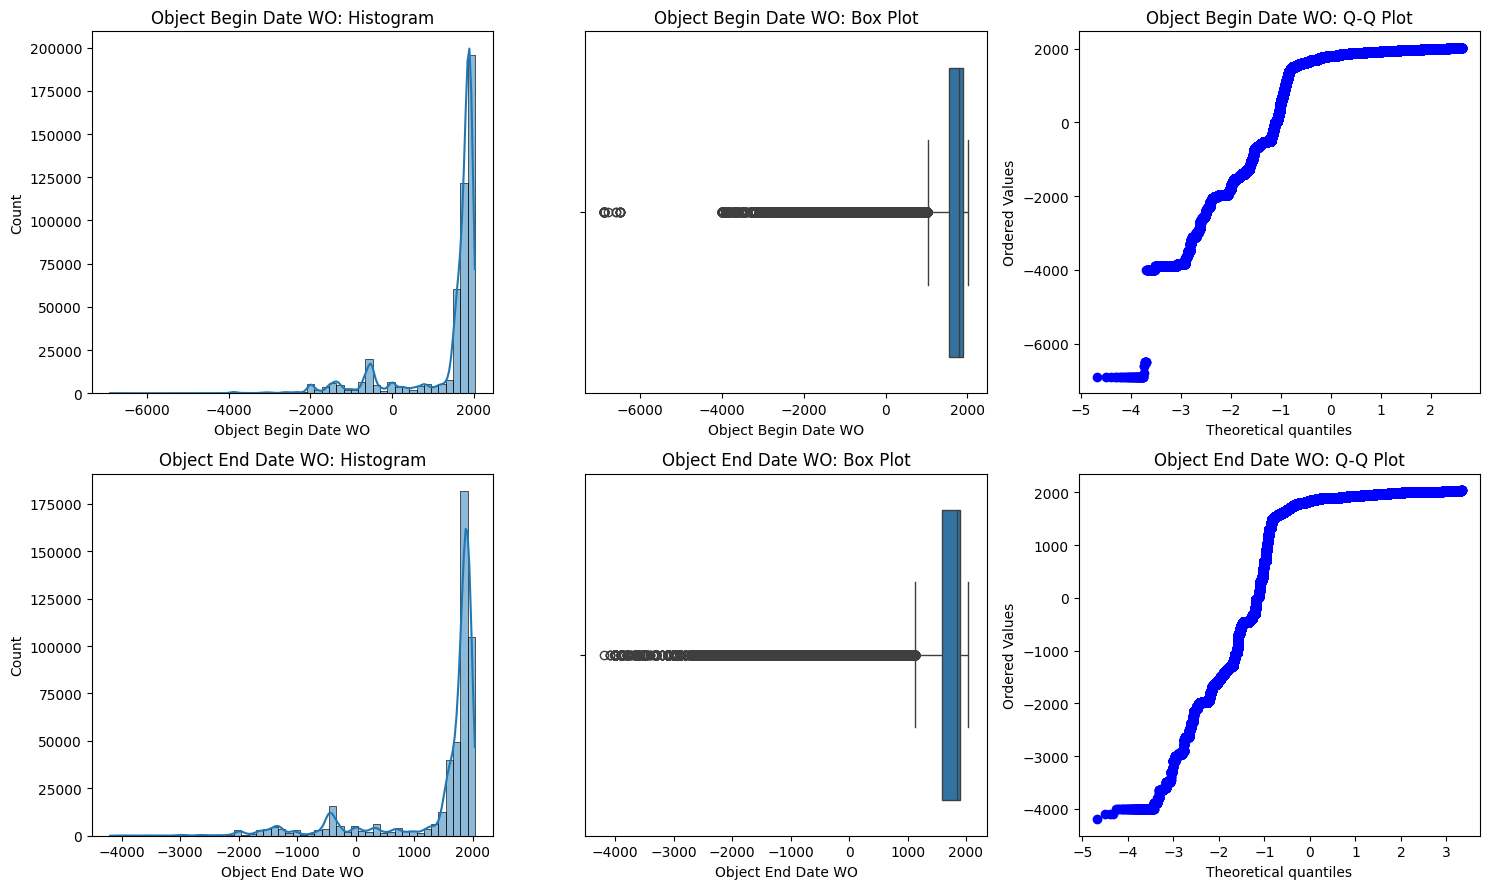

In [46]:
def plot_feature_distribution(df, column_name, position):
    # Histogram
    plt.subplot(2, 3, position[0] * 3 + position[1] + 1)
    sns.histplot(df[column_name], kde=True, bins=50)
    plt.title(f'{column_name}: Histogram')

    # Box Plot
    plt.subplot(2, 3, position[0] * 3 + position[1] + 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'{column_name}: Box Plot')

    # Q-Q Plot
    plt.subplot(2, 3, position[0] * 3 + position[1] + 3)
    stats.probplot(df[column_name], dist="norm", plot=plt)
    plt.title(f'{column_name}: Q-Q Plot')

plt.figure(figsize=(15, 9))

plot_feature_distribution(df51, 'Object Begin Date WO', (0, 0))
plot_feature_distribution(df51, 'Object End Date WO', (1, 0))

plt.tight_layout()
plt.show()

- It seems that there are still some outliers in `Object Begin Date WO`. Let's simply delete those that are less than -5000.

In [47]:
df51['Object Begin Date WO'] = df51['Object Begin Date WO'].where(
  df51['Object Begin Date WO'] > -5000,
  other=pd.NA
)
df51.describe()

Object Begin Date  Object End Date  Object Begin Date WO  \
count      484956.000000    484956.000000         482790.000000   
mean         1303.913734      1402.978142           1346.427917   
std          1710.259182      1132.101347           1034.018313   
min       -400000.000000   -240000.000000          -3999.000000   
25%          1535.000000      1593.000000           1544.000000   
50%          1800.000000      1840.000000           1800.000000   
75%          1891.000000      1905.000000           1891.000000   
max          5000.000000      2870.000000           2022.000000   

       Object End Date WO  
count       484751.000000  
mean          1407.614138  
std            980.192845  
min          -4200.000000  
25%           1594.000000  
50%           1840.000000  
75%           1905.000000  
max           2040.000000

 - We did not change the mean values significantly, but we normalized extreme values to fall within the possible intervals for these features. Therefore, I consider these features cleaned of outliers for potential further work with them.

In [48]:
df51.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Object Begin Date     484956 non-null  int64  
 1   Object End Date       484956 non-null  int64  
 2   Object Begin Date WO  482790 non-null  float64
 3   Object End Date WO    484751 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 14.8 MB


- As for why we did not use the **IQR** or **Z-score** methods to calculate outliers: the data **is not normally distributed**, and relying on quantiles could result in the removal of a significant amount of data below zero. Therefore, we do not want to be overly strict in this approach.

#### 5.2 Advaced method for identifying outliers - `Geography Type`

In [49]:
unique_geography_types = df['Geography Type'].dropna().unique()
print(len(unique_geography_types))

118


- Having only 118 unique elements it seems we can try to find outliers from this feature using a bit advanced approach



- Before diving into the code, let's outline the overall approach and assumptions for the clustering task. The goal is to find an outliers' cluster using a density-based clustering algorithm (**HDBSCAN**), which can handle clusters of varying shapes and sizes, along with noise points. The first step involves converting the textual data into numerical representations using sentence embeddings, which are able to capture the semantic relationships between different geographic types, enabling more accurate clustering based on meaning rather than just surface-level similarities.

- With the embeddings prepared, the next step is to fine-tune the HDBSCAN algorithm by searching for the optimal values of its key parameters: **min_cluster_size** and **min_samples**. A grid search is conducted over a range of values to find the parameter set that maximizes the **Silhouette Score** (https://en.wikipedia.org/wiki/Silhouette_(clustering)), which evaluates how well-defined the clusters are.

- After finding the optimal parameters, the HDBSCAN model is fitted to the embeddings, generating cluster labels for each geographical type. The number of points in each cluster, including noise points (data that doesn't fit into any cluster), is then counted.

- The following tutorials helped me to come up with this solution (and a **minor help** of well-known LLM):
  - https://hdbscan.readthedocs.io/en/latest/parameter_selection.html - general information about this clustering method and parameters;
  - https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis.html - choosing the number of clusters using **silhouette score**

In [50]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = model.encode(unique_geography_types)

def find_optimal_clusters(embeddings, min_cluster_size_range, min_samples_range):
  best_score = -1
  best_params = None
  scores = []

  for min_cluster_size in min_cluster_size_range:
    for min_samples in min_samples_range:
      clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
      cluster_labels = clusterer.fit_predict(embeddings)

      if len(np.unique(cluster_labels)) > 1:  # Ensure we have more than one cluster
        score = silhouette_score(embeddings, cluster_labels)
        scores.append((min_cluster_size, min_samples, score))

        if score > best_score:
          best_score = score
          best_params = (min_cluster_size, min_samples)

  return best_params, scores

# Find optimal parameters
min_cluster_size_range = range(2, 20)
min_samples_range = range(1, 10)
best_params, scores = find_optimal_clusters(embeddings, min_cluster_size_range, min_samples_range)

print(f"Best parameters: min_cluster_size={best_params[0]}, min_samples={best_params[1]}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Best parameters: min_cluster_size=5, min_samples=3


In [51]:
# Perform clustering with optimal parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_params[0], min_samples=best_params[1], metric='euclidean')
cluster_labels = clusterer.fit_predict(embeddings)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

print("\nNumber of elements in each cluster:")
for label, count in zip(unique_labels, counts):
  if label == -1:
    print(f"Noise points: {count}")
  else:
    print(f"Cluster {label}: {count}")

print("\nExamples from each cluster:")
for label in unique_labels:
  print(f"################## Label: {label} ##################")
  if label == -1:
    print(f"Noise points examples: {unique_geography_types[cluster_labels == -1][:10]}")
  else:
    print(f"Cluster {label} examples: {unique_geography_types[cluster_labels == label][:10]}")

  print("##############################################")


Number of elements in each cluster:
Noise points: 5
Cluster 0: 103
Cluster 1: 10

Examples from each cluster:
################## Label: -1 ##################
Noise points examples: ['Mint' 'Excavated in|Mint' 'From|Mint' 'Found|Mint' 'Object place']
##############################################
################## Label: 0 ##################
Cluster 0 examples: ['Made in' 'Probably made in' 'Possibly made in|Possibly made in'
 'Made in|Probably made in' 'Possibly made in' 'Made in|Made in'
 'Probably made in|Possibly made in' 'Made in|Possibly made in'
 'Made in|Probably made in|Probably made in' 'Made in|Object place']
##############################################
################## Label: 1 ##################
Cluster 1 examples: ['(none assigned)' 'Made in|(none assigned)'
 '(none assigned)|Probably made in' '(none assigned)|(none assigned)'
 'Formerly considered made in|(none assigned)'
 '(none assigned)|Formerly considered made in' 'From|(none assigned)'
 'From|(none assigned)|Po

- Looking at the content of cluster 1 we can say that in our case it found outliers, which have in common (none assigned). In case of string data it is a good example how outliers could look like.

### 6. Detect missing data in at least **three features**, convert them to a proper representation (if they are already not), and **impute missing values** in at least one feature using some imputation method.

In [59]:
pd.set_option('display.max_rows', 20)
print(df.isnull().sum().head(20))
pd.reset_option('display.max_rows')

Object Number               0
Is Highlight                0
Is Timeline Work            0
Is Public Domain            0
Object ID                   0
Gallery Number         435415
Department                  0
AccessionYear            3862
Object Name              2266
Title                   28803
Culture                276766
Period                 393813
Dynasty                461781
Reign                  473720
Portfolio              458442
Constituent ID         202443
Artist Role            202443
Artist Prefix          202443
Artist Display Name    202443
Artist Display Bio     204533
dtype: int64


#### 6.1 `Artist Gender`

- We will use the feature `Artist Display Name` to help us count the number of artists in a value.
- As shown in the previous data exploration, the `|` symbol is used as a separator for multiple objects, so we can utilize this in our analysis.

In [60]:
df61 = df[['Artist Display Name', 'Artist Gender']]
df61.sample(n=20, random_state=1)

Artist Display Name Artist Gender
319102                                            NaN           NaN
154091                  Group of the Boeotian Dancers           NaN
91880                                   Charles James           NaN
227310                                 Filippo d'Azon           NaN
470130                                   Gareth Mason           NaN
272592  Giovanni Battista Piranesi|Francesco Piranesi             |
105782                           André Charles Boulle           NaN
4598                                              NaN           NaN
264538                                Battista Franco           NaN
366492                                            NaN           NaN
419868                                            NaN           NaN
280731                       Jacques Callot|Anonymous             |
410389                                            NaN           NaN
360392                                            NaN           NaN
305230                                            NaN           NaN
72120                                             NaN           NaN
466151                                            NaN           NaN
207481                               Carlo Fantaccini           NaN
13499                                      Emil Fuchs           NaN
454361                      Topps Chewing Gum Company           NaN

In [61]:
df61.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Artist Display Name  282513 non-null  object
 1   Artist Gender        106482 non-null  object
dtypes: object(2)
memory usage: 7.4+ MB


- Let's check if our assumption is correct and that most of the **non-NA** values contain the same number of **|** symbols.

In [62]:
def count_different_pipe_symbols(df, feature1, feature2):
  filtered_df = df[df[feature1].notna() & df[feature2].notna()]

  feature1_pipe_count = filtered_df[feature1].str.count('\|')
  feature2_pipe_count = filtered_df[feature2].str.count('\|')

  different_count = (feature1_pipe_count != feature2_pipe_count).sum()
  return different_count

In [63]:
print(f"Ratio of different rows: {round(100 * count_different_pipe_symbols(df61, 'Artist Display Name', 'Artist Gender') / df61.dropna().count(), 2)}")

Ratio of different rows: Artist Display Name    0.0
Artist Gender          0.0
dtype: float64


- This result confirms our assumption, allowing us to identify the unique number of genders and fill in the missing values with the label **'unknown'**.

In [64]:
def count_unique_genders(series):
  all_genders = series.dropna().str.cat(sep='|').split('|')
  return set(all_genders)

count_unique_genders(df61['Artist Gender'])

{'', 'Female'}

- Having both 'Female' and an empty string as gender entries is quite peculiar; nonetheless, let's proceed to work with the data we have.

In [65]:
df61.dropna().count()

Artist Display Name    106482
Artist Gender          106482
dtype: int64

- Processe each row to clean and standardize the `Artist Gender` feature based on the `Artist Display Name` feature;
it returns 'unknown' if the `Artist Display Name` is missing, replaces any empty or missing gender values with 'unknown',
and retains valid gender entries, joining multiple values with a delimeter `|`

In [66]:
def process_artist_gender(row):
  if pd.isna(row['Artist Display Name']):
    return 'unknown'

  if pd.isna(row['Artist Gender']):
    count = len(row['Artist Display Name'].split('|'))
    return '|'.join(["unknown"] * count)

  genders = row['Artist Gender'].split('|')

  processed_genders = []
  for gender in genders:
    cleaned_gender = gender.strip()
    if cleaned_gender == '':
      processed_genders.append('unknown')
    else:
      processed_genders.append(cleaned_gender)

  return '|'.join(processed_genders)

df61['Artist Gender'] = df61.apply(process_artist_gender, axis=1)

In [67]:
df61['Artist Gender'].value_counts().head(10)

Artist Gender
unknown                                                    378474
unknown|unknown                                             58718
unknown|unknown|unknown                                     21654
Female                                                       8915
unknown|unknown|unknown|unknown                              6685
Female|unknown                                               2720
unknown|unknown|unknown|unknown|unknown                      2227
unknown|Female                                               1052
unknown|unknown|unknown|unknown|unknown|unknown               811
unknown|unknown|unknown|unknown|unknown|unknown|unknown       695
Name: count, dtype: int64

In [68]:
df61.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Artist Display Name  282513 non-null  object
 1   Artist Gender        484956 non-null  object
dtypes: object(2)
memory usage: 7.4+ MB


- The same value for total entries and non-null values in the `Artist Gender` feature indicates successful data imputation.

#### 6.2 `Object Date`

In [69]:
df62 = df[['Object Date', 'Object Begin Date', 'Object End Date']]

In [70]:
df62.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Object Date        471525 non-null  object
 1   Object Begin Date  484956 non-null  int64 
 2   Object End Date    484956 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.1+ MB


- From the information about our subdataframe, we can see that some values in the **Object Date** feature are missing. Therefore, we can try to impute them. However, first, let’s visually inspect the data to see if we can identify any **potential relationships** between these features. Based on their **names**, we would expect some correlation to exist.

In [71]:
df62.dropna().drop_duplicates().sample(n=30, random_state=42)

Object Date  Object Begin Date  Object End Date
117244  modeled ca. 1899, cast 1980               1894             1980
211519                  ca. 1517–19               1500             1534
184545                June 30, 1972               1972             1972
218595                   after 1847               1847             1860
341156           ca. 1320–1200 B.C.              -1320            -1320
455428                  ca. 1925–35               1920             1935
110855                      1725–27               1725             1727
30987                 probably 1798               1796             1800
205487                   March 1851               1845             1855
155939                ca. 40–20 BCE                -40              -20
1811                         1907–9               1907             1909
397403           July–December 1810               1810             1810
39501                      ca. 1530               1520             1540
145930              ca. 430–410 BCE               -430             -410
204088                      1645–86               1645             1686
108704                       1806–7               1806             1807
425292                      1847–70               1842             1875
231354                  1771–75 (?)               1771             1775
81300                       1924–28               1924             1928
328223                         n.d.               1926             1995
195170                 20th century               1875             1999
175241                      1948–74               1948             1974
17085                      ca. 1899               1894             1904
257460             November 6, 1783               1783             1783
395591           August 16–17, 1857               1857             1857
440310               March 12, 1864               1864             1864
177260                June 14, 1958               1958             1958
317474                ca. 1495–1510               1492             1513
30265            ca. 1500 and later               1475             1960
182842                        1850s               1853             1859

- Looking at this data the most simple pattern what can exist to impute values is:
  - Dates less than 0: `Object Date`=`f"{Object Begin Date}-{Object End Date} BCE"`
  - Dates greater than 0: `Object Date`=`f"{Object Begin Date}-{Object End Date}"`
- I also noticed instances of "**n.d.**", which can indicate missing data. Therefore, let's proceed to impute these values as well.

In [72]:
def impute_object_date(row):
  if pd.isna(row['Object Date']) or (isinstance(row['Object Date'], str) and row['Object Date'].lower() == 'n.d.' or row['Object Date'].lower() == 'unknown'):
    begin_date = row['Object Begin Date']
    end_date = row['Object End Date']

    if begin_date == end_date:
      return str(abs(begin_date))
    elif begin_date < 0 and end_date < 0:
      return f"{abs(begin_date)}-{abs(end_date)} BCE"
    else:
      return f"{abs(begin_date)}-{abs(end_date)}"

  return row['Object Date']

df62['Object Date'] = df62.apply(impute_object_date, axis=1)

In [74]:
df62.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Object Date        484956 non-null  object
 1   Object Begin Date  484956 non-null  int64 
 2   Object End Date    484956 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.1+ MB


In [75]:
df62.drop_duplicates().sample(n=30, random_state=69)

Object Date  Object Begin Date  \
117232                                      1558               1558   
202627                          ca. 14th century               1300   
303451                dated A.H. 1268/1851–52 CE               1826   
313284  early 20th century (original dated 1106)               1106   
179570                              June 8, 1850               1850   
204105                                 1690-1723               1690   
265750                               ca. 1530–62               1530   
293073                                 1536-1600               1536   
341638                        ca. 1859–1813 B.C.              -1859   
176937                                   1948–51               1948   
138334                    1828, cast before 1844               1828   
461913                               ca. 1741–86               1736   
459347                                 1640–1651               1640   
137842                                   1844–56               1844   
195382                      7th–10th century (?)                575   
479779                              June 4, 1857               1857   
101951                               ca. 1868–75               1863   
9383                                    1898 (?)               1898   
47189                                ca. 1730–40               1720   
227972                             1820 or later               1820   
353030                                    174 BC               -174   
385988                                   ca 1774               1774   
209335                                    1608–9               1608   
435794                               ca. 1908–13               1908   
475099                             probably 1836               1836   
96685                                    1968–75               1968   
156478                   1949, printed ca. 1970s               1949   
233040                                 1655-1714               1655   
137862                             ca. 1891–1900               1886   
206842                              20th century               1930   

        Object End Date  
117232             1558  
202627             1400  
303451             1876  
313284             1106  
179570             1850  
204105             1723  
265750             1562  
293073             1600  
341638            -1813  
176937             1951  
138334             1844  
461913             1786  
459347             1651  
137842             1856  
195382             1100  
479779             1857  
101951             1875  
9383               1898  
47189              1750  
227972             1899  
353030             -174  
385988             1774  
209335             1609  
435794             1913  
475099             1836  
96685              1975  
156478             1970  
233040             1714  
137862             1905  
206842             1999

#### 6.3 `Dynasty`

In [76]:
df63 = pd.concat([df51, df['Dynasty']], axis=1)
df63_clean = df63.dropna(subset=['Object Begin Date', 'Object End Date', 'Dynasty'])
df63_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23175 entries, 202375 to 484362
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Object Begin Date     23175 non-null  int64  
 1   Object End Date       23175 non-null  int64  
 2   Object Begin Date WO  23174 non-null  float64
 3   Object End Date WO    23175 non-null  float64
 4   Dynasty               23175 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.1 MB


- Data preprocessing => normalization between 0 and 1 helps the training process;
- Variables encoding => convert **Dynasty** feature from categorical into numerical

In [101]:
scaler = MinMaxScaler()
df63_clean[['Object Begin Date', 'Object End Date']] = scaler.fit_transform(df63_clean[['Object Begin Date', 'Object End Date']])

X = df63_clean[['Object Begin Date', 'Object End Date']].values
y = df63_clean['Dynasty'].values

unique_dynasties = np.unique(y)
dynasty_to_index = {dynasty: index for index, dynasty in enumerate(unique_dynasties)}
index_to_dynasty = {index: dynasty for dynasty, index in dynasty_to_index.items()}

y = np.array([dynasty_to_index[dynasty] for dynasty in y])

- This code defines a custom dataset class to store input data (**X**) and labels (**y**) as tensors and implements two key methods: __len__() and __getitem__(). This class helps organize data for model training in PyTorch.

In [102]:
class DynastyDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

- This is a PyTorch Lightning module that defines a Multi-Layer Perceptron (MLP) for `Dynasty` feature classification. The __init__ method creates a dynamic architecture based on the input parameters (I chose more layers to force this model to look for non-linear, non-trivial patterns in the data).

- It uses ReLU activation and dropout for regularization, which is quite popular in lightweight ML models.

- The **configure_optimizers** method sets up the **Adam** optimizer and **ReduceLROnPlateau** scheduler, which were suggested to me by a well-known LLM. The choice of optimizers is a quite complex task, and this particular task does not require manual calibration of the optimizer based on scores and results, so let's use it (of course, after gaining some insights from the pages I've linked).

In [103]:
# Multi-Layer Perceptron
class DynastyClassifier(pl.LightningModule):
  # Dropout introduced to prevent overfitting by randomly turning off a fraction of neurons during training
  def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
    super(DynastyClassifier, self).__init__()
    layers = []
    for i in range(len(hidden_sizes)):
      if i == 0:
        layers.append(torch.nn.Linear(input_size, hidden_sizes[i]))
      else:
        layers.append(torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

      layers.append(torch.nn.ReLU())
      layers.append(torch.nn.Dropout(dropout_rate))

    layers.append(torch.nn.Linear(hidden_sizes[-1], output_size))
    self.layers = torch.nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

  def training_step(self, batch, batch_idx):
    X, y = batch
    logits = self.forward(X)
    loss = F.cross_entropy(logits, y)
    return loss

  def validation_step(self, batch, batch_idx):
    X, y = batch
    logits = self.forward(X)
    loss = F.cross_entropy(logits, y)
    acc = (logits.argmax(dim=1) == y).float().mean()
    self.log('val_loss', loss, prog_bar=True)
    self.log('val_acc', acc, prog_bar=True)
    return {'val_loss': loss, 'val_acc': acc}

  def on_validation_epoch_end(self):
    avg_loss = self.trainer.callback_metrics['val_loss']
    avg_acc = self.trainer.callback_metrics['val_acc']
    self.log('val_loss', avg_loss, prog_bar=True)
    self.log('val_acc', avg_acc, prog_bar=True)

  def configure_optimizers(self):
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

    # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    return {
      'optimizer': optimizer,
      'lr_scheduler': scheduler,
      'monitor': 'val_loss'
    }

- We will perform **k-fold cross-validation** because we do not have a large dataset to separate into distinct training, validation, and test sets. For this case, cross-validation is a more suitable approach. After several experimental runs, I decided to use **5** folds with **50** epochs each. This configuration allows us to achieve satisfactory results on our dataset while balancing computational cost and model performance.

1. It maximizes the use of our limited data, as each data point gets to be in the validation set once and in the training set k-1 times.
2. It provides a more robust estimate of the model's performance by reducing the impact of how the data is split.
3. It helps to detect overfitting, as we can observe if the model performs consistently across different subsets of the data.

In [104]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accelerator = "cuda" if torch.cuda.is_available() else "cpu"
accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
  print(f"Fold {fold}")

  X_train, X_val = X[train_idx], X[val_idx]
  y_train, y_val = y[train_idx], y[val_idx]

  train_dataset = DynastyDataset(X_train, y_train)
  val_dataset = DynastyDataset(X_val, y_val)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=64)

  model = DynastyClassifier(2, [128, 64, 32], len(unique_dynasties))

  early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')
  trainer = pl.Trainer(max_epochs=50, callbacks=[early_stop_callback], accelerator=accelerator)
  trainer.fit(model, train_loader, val_loader)

  val_results = trainer.validate(model, val_loader)
  accuracies.append(val_results[0]['val_acc'])

print(f"Mean accuracy across folds: {np.mean(accuracies):.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fold 1


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 11.7 K | train
----------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8798273801803589     │
│         val_loss          │    0.5122383832931519     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 11.7 K | train
----------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Fold 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8826321363449097     │
│         val_loss          │    0.4269718825817108     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 11.7 K | train
----------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Fold 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8705501556396484     │
│         val_loss          │    0.4312591552734375     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 11.7 K | train
----------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Fold 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8817691206932068     │
│         val_loss          │    0.43365660309791565    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 11.7 K | train
----------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Fold 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.862351655960083     │
│         val_loss          │    0.42309099435806274    │
└───────────────────────────┴───────────────────────────┘

Mean accuracy across folds: 0.8754


- Turn the gradient calculations off and evaluate the model

In [105]:
model.eval()
with torch.no_grad():
  all_X = torch.tensor(X_val, dtype=torch.float32)
  all_y = torch.tensor(y_val, dtype=torch.long)

  # Make predictions
  predictions = model(all_X)
  predicted_classes = predictions.argmax(dim=1)

  # Calculate accuracy
  correct_predictions = (predicted_classes == all_y).sum().item()
  total_samples = len(all_y)
  accuracy_percentage = (correct_predictions / total_samples) * 100

print(f"\nOverall Accuracy on Validation Set: {accuracy_percentage:.2f}%")
print(f"Correctly predicted {correct_predictions} out of {total_samples} samples.")


Overall Accuracy on Validation Set: 86.24%
Correctly predicted 3997 out of 4635 samples.


- Our model was able to somehow determine a non-linear pattern between [**Object Begin Date**, **Object End Date**] and **Dynasty** features, so with accuracy of more than 85 percent we are able to impute missing values.

In [106]:
with torch.no_grad():
  def predict_dynasty(begin_date, end_date):
    input_data = scaler.transform([[begin_date, end_date]])
    input_tensor = torch.tensor(input_data, dtype=torch.float32)

    prediction = model(input_tensor)
    predicted_class = prediction.argmax(dim=1).item()
    return index_to_dynasty[predicted_class]

- Example how it works

In [107]:
begin_date = 1500
end_date = 1600

predicted_dynasty = predict_dynasty(begin_date, end_date)
print(f"For an object with begin date {begin_date} and end date {end_date}, the predicted dynasty is: {predicted_dynasty}")

For an object with begin date 1500 and end date 1600, the predicted dynasty is: 26.0


- Let's impute the `Dynasty` feature

In [108]:
df63['Object Begin Date'] = pd.to_numeric(df63['Object Begin Date'], errors='coerce')
df63['Object End Date'] = pd.to_numeric(df63['Object End Date'], errors='coerce')

def predict_row_dynasty(row):
    if pd.isna(row['Dynasty']) and not pd.isna(row['Object Begin Date']) and not pd.isna(row['Object End Date']):
        begin_date = int(row['Object Begin Date'])
        end_date = int(row['Object End Date'])
        return predict_dynasty(begin_date, end_date)
    return row['Dynasty']

df63['Dynasty'] = df63.apply(predict_row_dynasty, axis=1)
df63.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Object Begin Date     484956 non-null  int64  
 1   Object End Date       484956 non-null  int64  
 2   Object Begin Date WO  482790 non-null  float64
 3   Object End Date WO    484751 non-null  float64
 4   Dynasty               484956 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 18.5 MB


### 7. Focus more precisely on **cleaning the "Medium" feature**. As if you were to use it in the **KNN classification** algorithm later.


- **KNN** (K-Nearest Neighbors) algorithm for strings requires clean and processed data to be able work with more precise embeddings. Even 'Word' and 'word!' will have similar embeddings, it better to have all values in one format to decrease risks and increase the performance of this algorithm.

In [77]:
unique_values = df['Medium'].dropna().unique()
pd.Series(unique_values).sample(30, random_state=69)

11727                                Silk and metal thread
49570    Copper (plaques): engraved, scraped, stippled,...
17335                                   teca, rayon staple
57098                  Cupreous metal, traces of gold leaf
44713    Monotype with watercolor, pastel, crayon and p...
50090                          Stone, with traces of paint
6185                              Wood, horn, bone, silver
51189                                  Lacquer on maranite
20725                            Glass, enamelled and gilt
34415                          Periodical with lithographs
48633    Transparent pale green glass, the handle perha...
19521                            silk, metal, shell, glass
39084    Etching and drypoint printed in brown ink on l...
43143              Brown ink over graphite with brown wash
51969    Oil and graphite on canvas, colored pencil and...
12353                          Watercolor and ink on paper
49547                      Jasper body, silver-gilt mounts
32973    Red chalk, brush and red wash, on light tan pa...
43102          Etching on laid paper; third state of three
27645                                  Stone, wood, string
20950                               Silver, crystal, agate
52765    Watercolor, graphite, and matte opaque paint o...
50813        Earthenware, glazed (green and white faience)
4233     Steel, wood, lacquer, ray skin (samé), copper,...
39591    Transfer lithograph with stumping; only state ...
35766                        Etching on chine collé; proof
21832    Case: painted enamel on gold; Movement: brass ...
53773    Sandpaper, gouache, mirror, and thread in wood...
5221                                   Steel, brass, ivory
51026                      100% Rovana, Saran Monofilament
dtype: object

- After listing 30 random unique values, we can proceed with the following steps:
  - Replace **NaN** values with the label '**unknown**' to create a separate cluster for them.
  - Convert all letters to lowercase.
  - Remove any **braces** and **their contents**, as they provide additional information rather than the main information.
  - Eliminate **multiple spaces**, **new lines**, and **punctuation** for cleaner data.

In [78]:
def first_clean_medium(medium):
  patterns = {
    'parenthesis': r'\([^)]*\)',
    'newline': r'[\n\r]',
    'spaces': r'\s+',
    'punctuation': r'[^\w\s]'
  }

  return (medium.fillna('unknown')
          .str.lower()
          .replace(patterns['parenthesis'], '', regex=True)
          .replace(patterns['newline'], '', regex=True)
          .replace(patterns['spaces'], ' ', regex=True)
          .replace(patterns['punctuation'], '', regex=True)
          .str.strip())

df7 = first_clean_medium(df['Medium'])

In [79]:
pd.Series(df7).sample(30, random_state=123)

221158                                illustrations etching
463408                                            engraving
363770                                                shell
210714                                 etching and drypoint
248932                                              etching
82190                                         metal leather
350820                                green glazed steatite
338379                                       wood hide cord
169719                                        film negative
166877                                 albumen silver print
160286                                 gelatin silver print
262934                                            engraving
451773                                 gelatin silver print
225809    pen and brown ink watercolor framing lines in ...
27185                                          steel silver
62271                                  silk  compound weave
167029                                 gelatin silver print
367813                                              linocut
481753                          commercial color lithograph
175362                                       platinum print
110122    figure softpaste biscuit porcelain base glazed...
431814                               etching printed in red
45151     white porcelain decorated with blue under the ...
234018                                etching and engraving
121664                                          bobbin lace
96558                                                cotton
356351                                                 gold
17280      steel wood lacquer coppergold alloy  gold copper
55302     polychrome woodblock print ink and color on paper
260150                                            engraving
Name: Medium, dtype: object

- Now the data seems clearer. Let's try to find some outliers by identifying words containing non-English symbols and numbers, and delete them from values (not whole rows, only specific words).

In [80]:
symbols = df7.str.findall(r'[^a-zA-Z\s]')
unique_symbols = set([symbol for sublist in symbols for symbol in sublist])

def second_medium_clean(x):
  for symbol in unique_symbols:
    pattern = r'\b\w[' + re.escape(symbol) + r']\w\b'
    x = re.sub(pattern, '', x, flags=re.IGNORECASE)

  x = re.sub(r'\s+', ' ', x)
  return x.strip()

df7 = df7.apply(second_medium_clean)

In [81]:
print(f"{round(100 - df7.nunique() * 100 / df['Medium'].nunique(), 2)}%")

12.05%


- After two cleaning functions, we reduced the number of unique elements by **12%**, which is quite good, but there is still enough room for improvement and further cleaning.
- Let's delete all stopwords and perform lemmatization, because we do not want to differentiate words like 'print', 'printing', 'printed', 'prints'.

In [82]:
stop_words = set(stopwords.words('english'))

def third_medium_clean(text):
  words = text.split()
  text = ' '.join(word for word in words if word not in stop_words)
  doc = nlp(text)
  return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

df7 = df7.apply(third_medium_clean)

- Now let's reduce the number of words by deleting infrequent words. (Yes, we will lose some information by reducing the potential number of clusters).

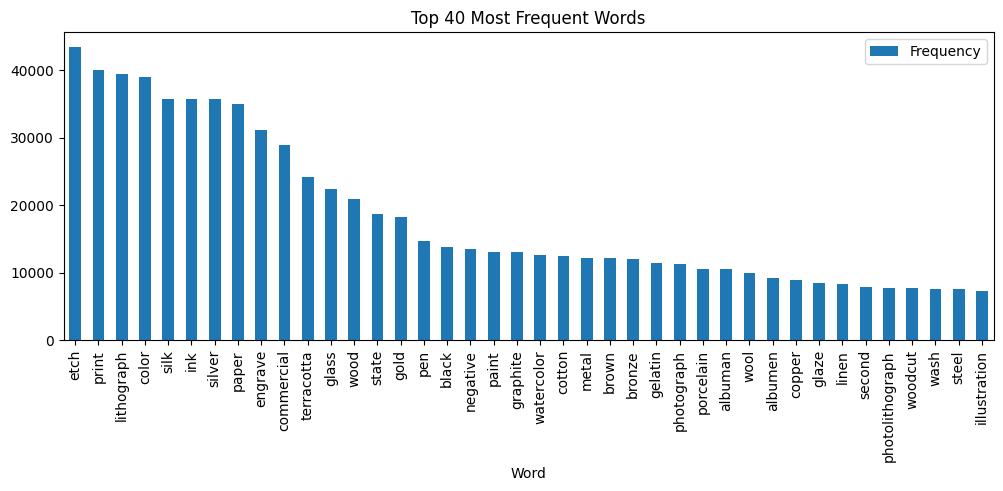

In [83]:
words = df7.str.split().explode()
word_counts = Counter(words)

word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
word_freq_df.head(40).plot(kind='bar', x='Word', y='Frequency', figsize=(12, 4), title="Top 40 Most Frequent Words")
plt.show()

- We can notice that the word **second** is in the top 40 most frequent words, but it describes a number. I am pretty sure we can delete it from the feature values. Let's also perform a last cleaning step by sorting words (we do not want to see a difference, in the case of clustering, between "print values" and "values print").

- The next function uses the **Cumulative Distribution Function** (CDF) approach to determine the optimal number of words that provide a good balance between coverage and vocabulary size. Here's how it works:

1. First sorts the words by frequency in descending order. It then calculates the cumulative sum of frequencies, normalized by the total frequency.

2. The function iterates through different coverage levels (from min_coverage to max_coverage). For each coverage level, it finds how many words are needed to achieve that coverage.

3. The key idea is to find the point where adding more words provides diminishing returns in terms of coverage. It calculates the rate of change in coverage for each additional word. The optimal point is identified when this rate drops below a small threshold (0.0001 in this case).

In [84]:
def find_optimal_word_coverage(word_freq_df, min_coverage=0.8, max_coverage=1, step=0.01):
  word_freq_df = word_freq_df.sort_values('Frequency', ascending=False).reset_index(drop=True)
  word_freq_df['Cumulative Coverage'] = word_freq_df['Frequency'].cumsum() / word_freq_df['Frequency'].sum()

  max_coverage = min(max_coverage, word_freq_df['Cumulative Coverage'].max())

  results = []
  for coverage in np.arange(min_coverage, max_coverage + step, step):
    matching_rows = word_freq_df[word_freq_df['Cumulative Coverage'] >= coverage]
    if matching_rows.empty:
      break

    cutoff = matching_rows.index[0]
    results.append((coverage, cutoff + 1))  # +1 because index is 0-based

  rates = [(results[i+1][0] - results[i][0]) / (results[i+1][1] - results[i][1]) for i in range(len(results)-1)]
  optimal_index = next(i for i, rate in enumerate(rates) if rate < 0.0001)
  optimal_coverage, optimal_words = results[optimal_index]

  print(f"Optimal balance: {optimal_words} most frequent words cover {optimal_coverage:.2%} of occurrences")
  return optimal_words, optimal_coverage

optimal_words, optimal_coverage = find_optimal_word_coverage(word_freq_df)

Optimal balance: 532 most frequent words cover 95.00% of occurrences


- Based on the optimal balance, we can keep only **532** frequent words to cover **95%** of all words. I think it is quite a good trade-off, but if a value contains only one word, we will keep it to reduce the number of unknown values which had some information.

In [85]:
number_words = ['first', 'one', 'second', 'two', 'third', 'three', 'fourth',
                'four', 'fifth', 'five', 'sixth', 'six', 'seventh', 'seven',
                'eighth', 'eight', 'ninth', 'nine', 'tenth', 'ten']

def fourth_medium_clean(words):
  words = {word for word in words.split(' ') if isinstance(word, str) and not word in number_words}
  sorted_words = sorted(words)
  return ' '.join(sorted_words)

df7 = df7.apply(fourth_medium_clean)

In [86]:
def keep_frequent_words(text, frequent_words):
  words = text.split(' ')
  if len(words) == 1 and words[0] not in frequent_words:
    return words[0]  # Keep single words even if not frequent

  return ' '.join(word for word in words if word in frequent_words)

frequent_words = set(word_freq_df.head(optimal_words)['Word'])
df7 = df7.apply(lambda x: keep_frequent_words(x, frequent_words))

print("Original 'Medium' unique values:", df['Medium'].nunique())
print("Cleaned 'Medium' unique values:", df7.nunique())
print(f"{round(100 - df7.nunique() * 100 / df['Medium'].nunique(), 2)}%")

Original 'Medium' unique values: 65907
Cleaned 'Medium' unique values: 37795
42.65%


- As a final result, we reduced the number of unique values by **almost 50%**, which is really good.

In [87]:
df7.value_counts()

Medium
terracotta                                                              23563
color commercial lithograph                                             19126
etch                                                                    17765
silk                                                                    13884
engrave                                                                 11999
                                                                        ...  
brown chalk light paper red stump                                           1
book gold ground lacquer polychrome print red woodblock                     1
fundame gold inlay interior ivory lacquer motherofpearl nashiji wood        1
chalk cream paper red square                                                1
black chalk gray heighten paper red white                                   1
Name: count, Length: 37795, dtype: int64

### 8. Focus on the **extraction of the physical dimensions** of each item (width, depth, and height in centimeters) from the `Dimensions` feature.

1. First step contains cleaning feature `Dimensions` from the trash like **no meas**, **\r\n** and other values, that were noticed during data understanding. I created array of them, which can help to remove **99%** of senseless values of this feature. Also i did not notice valuable inforamtion in strings with length less than 4, so we can also delete them.

In [88]:
init_count_df = df['Dimensions'].count()

In [89]:
trash_values = [
  'unavailable', 'unrecorded', 'no dimensions', 'cut',
  'see attached list', 'vary', 'unknown', 'no meas', 'not meas'
  'not available', 'see', 'not recorded', 'sample', 'cannot'
]

In [90]:
def first_clean(x):
  if not isinstance(x, str):  # Handle NaN or missing values
    return pd.NA

  if len(x) < 4 or any(val in x.lower() for val in trash_values):
    return pd.NA

  return x

In [91]:
df8 = df['Dimensions'].apply(first_clean)
print(f"Ratio of cleaned data: {round(100 - df8.count() / df['Dimensions'].count() * 100, 2)}%")

df8 = pd.DataFrame({
  'Dimensions': df8,
  'Width': pd.NA,
  'Height': pd.NA,
  'Depth': pd.NA
})

Ratio of cleaned data: 0.47%


In [92]:
print_value_counts(df8['Dimensions'], 20)

Dimensions
sheet: 2 11/16 x 1 3/8 in. (6.9 x 3.5 cm)    2297
Sheet: 2 3/4 x 1 1/2 in. (7 x 3.8 cm)        2278
Sheet: 2 1/2 × 1 7/16 in. (6.4 × 3.7 cm)     2141
Sheet: 2 3/4 × 1 1/2 in. (7 × 3.8 cm)        1966
35mm                                         1458
Sheet: 2 11/16 × 1 3/8 in. (6.8 × 3.5 cm)    1319
4 x 5 in.                                    1307
Sheet: 2 3/4 x 1 3/8 in. (7 x 3.5 cm)        1151
Approx. 3 1/2 × 7 in. (8.9 × 17.8 cm)         989
Sheet: 2 5/8 × 1 1/2 in. (6.7 × 3.8 cm)       921
Sheet: 3 1/2 × 2 1/2 in. (8.9 × 6.4 cm)       887
Sheet: 3 1/2 × 2 1/2 in. (8.9 × 6.3 cm)       873
Sheet: 5 3/8 × 3 3/8 in. (13.6 × 8.5 cm)      782
Approx. 10.2 x 6.3 cm (4 x 2 1/2 in.)         780
8 x 10 in.                                    767
7.9 x 7.9 cm (3 1/8 x 3 1/8 in.)              734
2 1/2 x 4 1/4 in.                             707
6 1/2 x 8 1/2 in.                             665
Sheet: 3 1/16 × 1 9/16 in. (7.7 × 4 cm)       645
Sheet: 2 5/8 × 1 7/16 in. (6.6 × 3.7 cm

2. I found 2 patterns which could work well for us: (`N \d N cm`) or (`N \d N \d N cm`), where **N** is a number and **d** is a delimiter. Why not others? They can contain information and confuse us with incorrect values. We will return to them later. So, the second step will be to catch the first bunch of values and extract **Width**, **Height**, and **Depth** for them.

In [93]:
def analyze_progress(df, stage):
  global init_count_df
  extracted_rows = df[df[['Width', 'Height', 'Depth']].notna().any(axis=1)]

  print(f"\n=== Stage {stage} ===")
  print(f"Ratio of processed rows: {round(len(extracted_rows) / init_count_df * 100, 2)}%")

In [94]:
fn = r'(\d+(?:\.\d+)?)'
d = r'[x×]'
regex1_3d = rf'\({fn}\s*{d}\s*{fn}\s*{d}\s*{fn}\s*cm\)'
regex1_2d = rf'\({fn}\s*{d}\s*{fn}\s*cm\)'
regex1_combined = f'{regex1_3d}|{regex1_2d}'
pattern1 = re.compile(regex1_combined, re.IGNORECASE)

def first_extract_dimensions(df):
  for idx, row in df.iterrows():
    dimension = row['Dimensions']

    if not isinstance(dimension, str):
      continue

    match = pattern1.search(dimension)
    if not match:
      continue

    filtered_groups = [group for group in match.groups() if group is not None]
    df.at[idx, 'Width'] = float(filtered_groups[0].strip())
    df.at[idx, 'Height'] = float(filtered_groups[1].strip())
    df.at[idx, 'Depth'] = float(filtered_groups[2].strip()) if len(filtered_groups) == 3 else pd.NA

  return df, df['Dimensions'].str.contains(pattern1, regex=True, na=False)

df81, mask81 = first_extract_dimensions(df8)
analyze_progress(df81, 1)


=== Stage 1 ===
Ratio of processed rows: 64.62%


3. We matched 64% of values using these 2 simple regexps, but we are able to catch more values. Lets look at the rest of data and think about next patterns we can use.

In [95]:
print_value_counts(df81[~mask81]['Dimensions'], 50)

Dimensions
35mm                                                                                                1458
4 x 5 in.                                                                                           1307
Approx. 10.2 x 6.3 cm (4 x 2 1/2 in.)                                                                780
8 x 10 in.                                                                                           767
7.9 x 7.9 cm (3 1/8 x 3 1/8 in.)                                                                     734
2 1/2 x 4 1/4 in.                                                                                    707
6 1/2 x 8 1/2 in.                                                                                    665
approx. 9 x 14 cm (3 9/16 x 5 1/2 in. )                                                              612
Length: 5 in. (12.7 cm)                                                                              482
10.5 x 7 x 0.5 cm (4 1/8 x 2 3/4 x 3/16 in.)

- After examining the remaining values, I identified new challenges and data issues we need to address:
  - **Diameter** and **Length**: We don't need to parse these values, but in some cases, they can be misinterpreted. Therefore, I've decided to remove them from our dataset.

  - New irrelevant terms: Words and phrases like "size varied", "variable", and similar expressions have been found. I've implemented a new filter to remove these from our analysis.

In [96]:
trash_values2 = [
  'various', 'size varied', 'variable', 'diam',
  'd.', 'dia.', 'l.', 'length'
]

def second_clean(x):
  if not isinstance(x, str):  # Handle NaN or missing values
    return pd.NA

  if any(val in x.lower() for val in trash_values2):
    return pd.NA

  return x

df82 = df81.copy()
df82['Dimensions'] = df81['Dimensions'].apply(second_clean)

# we need to cleare previous misinterpeted values from Dimensions
mask_clean = df82['Dimensions'].isna()
df82.loc[mask_clean, 'Width'] = pd.NA
df82.loc[mask_clean, 'Depth'] = pd.NA
df82.loc[mask_clean, 'Height'] = pd.NA

analyze_progress(df82, 2)


=== Stage 2 ===
Ratio of processed rows: 61.44%


- As we can notice, the number of processed rows has decreased. This means that the cleaning was worth it.

4. The next step will be to extract dimensions separately.

In [97]:
def second_extract_dimensions(df):
  masks = {
    'Width' : df['Dimensions'].str.contains(r'W\.|Width', case=False, na=False),
    'Height' : df['Dimensions'].str.contains(r'H\.|Height', case=False, na=False),
    'Depth' : df['Dimensions'].str.contains(r'D\.|Depth', case=False, na=False)
  }

  for idx, row in df.iterrows():
    dimension = row['Dimensions']

    if not isinstance(dimension, str):
      continue

    for name, mask in masks.items():
      if mask[idx]:
          matches = re.findall(fn, dimension) # fn - number
          if matches:
            df.at[idx, name] = float(matches[0])

  return df, masks['Width'] | masks['Height'] | masks['Depth']

df83, mask83 = second_extract_dimensions(df82)
analyze_progress(df83, 3)


=== Stage 3 ===
Ratio of processed rows: 70.96%


In [98]:
print_value_counts(df83[~(mask81 | mask83)]['Dimensions'], 50)

Dimensions
35mm                                                                                                        1458
4 x 5 in.                                                                                                   1307
Approx. 10.2 x 6.3 cm (4 x 2 1/2 in.)                                                                        780
8 x 10 in.                                                                                                   767
7.9 x 7.9 cm (3 1/8 x 3 1/8 in.)                                                                             734
2 1/2 x 4 1/4 in.                                                                                            707
6 1/2 x 8 1/2 in.                                                                                            665
approx. 9 x 14 cm (3 9/16 x 5 1/2 in. )                                                                      612
10.5 x 7 x 0.5 cm (4 1/8 x 2 3/4 x 3/16 in.) each                                    

5. Now we are ready to perform our last extraction from the rest of the data. In case of multiple dimensions, I will take only the first occurrence.

In [99]:
regex2_3d = rf'{fn}\s*{d}\s*{fn}\s*{d}\s*{fn}\s*cm'
regex2_2d = rf'{fn}\s*{d}\s*{fn}\s*cm'
regex2_1d = rf'\({fn}\s*cm\)'
regex2_1dunbr = rf'{fn}\s*cm'
regex2_combined = f'{regex2_3d}|{regex2_2d}|{regex2_1d}|{regex2_1dunbr}'
pattern2 = re.compile(regex2_combined, re.IGNORECASE)

def third_extract_dimensions(df):
  for idx, row in df.iterrows():
    dimension = row['Dimensions']

    if not isinstance(dimension, str):
      continue

    match = pattern2.search(dimension)
    if not match:
      continue

    filtered_groups = [group for group in match.groups() if group is not None]
    df.at[idx, 'Width'] = float(filtered_groups[0].strip())
    df.at[idx, 'Height'] = float(filtered_groups[1].strip()) if len(filtered_groups) == 2 else pd.NA
    df.at[idx, 'Depth'] = float(filtered_groups[2].strip()) if len(filtered_groups) == 3 else pd.NA

  return df, df['Dimensions'].str.contains(pattern2, regex=True, na=False)

df84, mask84 = third_extract_dimensions(df83)
analyze_progress(df84, 4)


=== Stage 4 ===
Ratio of processed rows: 77.22%


- We were able to extract more than **75%** of dimensions. It is a good result, but there is still space for improvement, for example:
  - Consider other measurements like **millimeters**, **inches**, and so on. It is possible to parse them and convert them into **centimeters**.
  - Consider other dimensions like diameter and length. This will give us ~ **10%** of new data.
  - Clean more trash data with no information.

In [100]:
print_value_counts(df[~(mask81 | mask83 | mask84)]['Dimensions'], 30)

Dimensions
35mm                                                                                                1458
4 x 5 in.                                                                                           1307
8 x 10 in.                                                                                           767
2 1/2 x 4 1/4 in.                                                                                    707
6 1/2 x 8 1/2 in.                                                                                    665
Length: 5 in. (12.7 cm)                                                                              482
Dimensions unavailable                                                                               385
5 x 7 in.                                                                                            359
2 1/4 x 2 1/4 in.                                                                                    236
Dimensions unrecorded                       